In [1]:
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt

In [2]:
#connect my db with sql database
conn = sqlite3.connect('superstore_database.db')
cursor = conn.cursor()

In [15]:
sql_query = """
    select c.CustomerName, c.State, count(*) from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID group by  c.CustomerName order by count(*) desc limit 10 
"""
pd.read_sql(sql_query, conn)

,CustomerName,State,count(*)
0,William Brown,Pennsylvania,37
1,Paul Prost,Georgia,34
2,Matt Abelman,Texas,34
3,John Lee,California,34
4,Seth Vernon,Delaware,32
5,Jonathan Doherty,Pennsylvania,32
6,Edward Hooks,New York,32
7,Chloris Kastensmidt,Pennsylvania,32
8,Zuschuss Carroll,Oregon,31
9,Emily Phan,Illinois,31


In [14]:
sql_query = """
    select c.CustomerName, c.State, count(*) from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID group by  c.State order by count(*) desc limit 10 
"""
pd.read_sql(sql_query, conn)

,CustomerName,State,count(*)
0,Darrin Van Huff,California,1998
1,Janet Molinari,New York,1110
2,Harold Pawlan,Texas,917
3,Sandra Flanagan,Pennsylvania,641
4,Linda Cazamias,Illinois,574
5,Ryan Crowe,Ohio,480
6,Irene Maddox,Washington,460
7,Andrew Allen,North Carolina,343
8,Brendan Sweed,Arizona,301
9,Sean O'Donnell,Florida,290


In [34]:
most_sales = """ 
select  c.State, sum(s.sales) as total_sales from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID  group by c.State order by sum(s.Sales) DESC limit 5

"""
pd.read_sql(most_sales,conn)


,State,total_sales
0,California,451036.5823
1,New York,279549.8235
2,Texas,192758.2049
3,Pennsylvania,142838.5510
4,Washington,133177.2518


/var/folders/_f/kkvs81ts6bn_m7y2gqnp_xjm0000gn/T/ipykernel_41079/2335969177.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


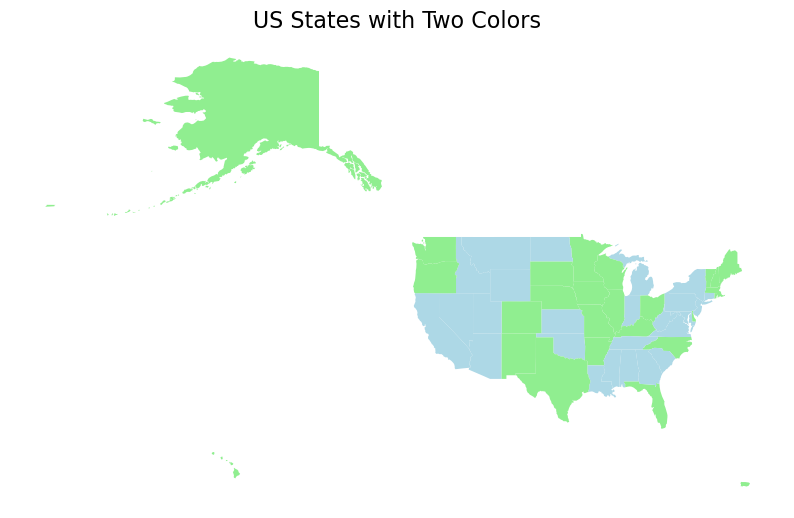

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load world data from Geopandas and filter only the USA
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world['iso_a3'] == 'USA']

# Load US states from a built-in dataset in Geopandas (you might need to load from shapefiles if needed)
# Geopandas does not have a built-in states dataset, but you can use a shapefile for US states
states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

# Plot the states with two alternating colors
fig, ax = plt.subplots(figsize=(10, 8))

# Apply alternating colors using 'facecolor'
states.plot(ax=ax, color=['lightblue' if i % 2 == 0 else 'lightgreen' for i in range(len(states))])

# Set title and remove axes for better aesthetics
ax.set_title('US States with Two Colors', fontsize=16)
ax.set_axis_off()  # Remove axes

# Show the plot
plt.show()